In [1]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import seaborn as sns
from datetime import date

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Environment settings: 
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [2]:
def get_page(url):
    """Download a webpage and return a beautiful soup doc"""
    ##### Web scrapper for infinite scrolling page #####
    driver = webdriver.Chrome(executable_path=r"E:\Chromedriver\chromedriver_win32_chrome83\chromedriver.exe")
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 1 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1

    while True:
        # scroll one screen height each time
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  
        # Break the loop when the height we need to scroll to is larger than the total scroll height
        if i == 10:
            break 

    ##### Extract Reddit URLs #####
    soup = BeautifulSoup(driver.page_source, "html.parser")
    return soup

In [3]:
def get_news_tags(doc):
    """Get the list of tags containing news information"""
    news_class = "Ov(h) Pend(44px) Pstart(25px)" ## class name of div tag 
    news_list  = doc.find_all('div', {'class': news_class})
    return news_list

In [4]:
BASE_URL = 'https://finance.yahoo.com' #Global Variable 

def parse_news(news_tag):
    """Get the news data point and return dictionary"""
    news_source = news_tag.find_all('span')[0].text #source
    news_time = news_tag.find_all('span')[1].text #time
    news_headline = news_tag.find('a').text #heading
    news_url = news_tag.find('a')['href'] #link
    news_content = news_tag.find('p').text #content
    news_image = news_tag.findParent().find('img')['src'] #thumb image
    return { 'source' : news_source,
            'time' : news_time,    
            'headline' : news_headline,
            'url' : BASE_URL + news_url,
            'content' : news_content,
           }

In [5]:
def scrape_yahoo_news(url, path=None):
    """Get the yahoo finance market news and write them to CSV file """
    if path is None:
        path = 'stock-market-news.csv'
        
    #print('Requesting html page')
    doc = get_page(url)

    #print('Extracting news tags')
    news_list = get_news_tags(doc)

    #print('Parsing news tags')
    news_data = [parse_news(news_tag) for news_tag in news_list]

    #print('Save the data to a CSV')
    news_df = pd.DataFrame(news_data)
    #news_df.to_csv(path, index=None)
    
    #This return statement is optional, we are doing this just analyze the final output 
    return news_df 

In [6]:
# url = 'https://finance.yahoo.com/topic/stock-market-news/'
# doc = get_page(url)
# news_list = get_news_tags(doc)
# news_list

## Entire Stock Market News

In [7]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Report Date = ", date.today())
print("Report Time =", current_time)
YAHOO_NEWS_URL = BASE_URL + '/topic/stock-market-news/'
news_df = scrape_yahoo_news(YAHOO_NEWS_URL)

Report Date =  2022-12-16
Report Time = 14:53:43


In [8]:
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [9]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [10]:
sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment'] = sentiment
news_df['Score'] = sentiment_score


sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['content']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment2'] = sentiment
news_df['Score2'] = sentiment_score

In [11]:
news_df[news_df['Score'] > 0.8]

,source,time,headline,url,content,Sentiment,Score,Sentiment2,Score2
0,Investor's Business Daily,10 minutes ago,LGI Homes Stock Shows Rising Price Performance With Jump To 85 RS Rating,https://finance.yahoo.com/m/6c4d68c9-03e8-3502-90a4-bf962a93edcf/lgi-homes-stock-shows-rising.html,"LGI Homes stock now meets that criteria, with an increase from 65 to 85 Friday. As you try to find the best stocks to buy and watch, keep a close on eye on relative price strength. Is LGI Homes Stock A Buy?",POSITIVE,0.980266,POSITIVE,0.997075
1,Investor's Business Daily,15 minutes ago,IPO Stock Of The Week: Solar Leader Array Technologies Triggers Sell Signal After Failed Breakout,https://finance.yahoo.com/m/f740d82e-3846-356c-823c-0bd87d787823/ipo-stock-of-the-week-solar.html,IPO Stock Of The Week pick solar leader Array Technologies triggered a key sell rule following its failed breakout move this week.,NEGATIVE,0.997177,NEGATIVE,0.999168
2,Investor's Business Daily,27 minutes ago,Inside the 50: Homebuilder Stocks Shine Despite Rising Mortgage Rates,https://finance.yahoo.com/m/ef79e2c4-c51b-37d5-a248-1823cef78bfe/inside-the-50-homebuilder.html,"It may be surprising that three homebuilder stocks have made it onto the elite IBD 50 list when mortgage rates have been on the rise. This surging industry group has soared over 25% quarter-to-date. Meritage Homes, PulteGroup and KB Home have been added to the IBD 50 in the last two weeks.",POSITIVE,0.999202,POSITIVE,0.998226
3,Barrons.com,31 minutes ago,DraftKings Is Questioned by the Market. Citi Says the Stock Is a Buy.,https://finance.yahoo.com/m/814461e7-310f-35ae-8003-22853821bb29/draftkings-is-questioned-by.html,Analyst Jason Bazinet says the online sports betting company doesn't get enough credit from the market.,NEGATIVE,0.995240,NEGATIVE,0.999748
4,The Wall Street Journal,32 minutes ago,Stocks Dragged Lower by Mounting Recession Concerns,https://finance.yahoo.com/m/bc4ba68b-44e2-3040-885a-b174be54cb88/stocks-dragged-lower-by.html,"Stocks fell again Friday, ending a week where central banks globally signaled their intent to rein in inflation with higher interest rates.",NEGATIVE,0.999497,NEGATIVE,0.998393
5,MarketWatch,32 minutes ago,Why a not-so-swift decline in U.S. inflation would keep financial markets turbulent through 2023,https://finance.yahoo.com/m/2d7acd3e-150d-3f4a-9ace-6452f2be5e40/why-a-not-so-swift-decline-in.html,"A path of slowly decelerating inflation would give investors optimism, but also disappoint Federal Reserve policy makers counting on a faster return to normal",NEGATIVE,0.997148,NEGATIVE,0.998150
6,Investor's Business Daily,36 minutes ago,"Steel Stocks, Mining Giants React As China Iron Ore Consortium Enters Market",https://finance.yahoo.com/m/1f03400f-1c00-3802-9cab-de2bde32171a/steel-stocks-mining-giants.html,Steel stocks were mixed Friday as mining stocks dropped. A China-run consortium may soon be the biggest buyer of iron ore.,POSITIVE,0.986058,NEGATIVE,0.981093
7,Yahoo Finance,39 minutes ago,Tesla stock is in the midst of its worst-ever drawdown,https://finance.yahoo.com/news/tesla-stock-price-history-worst-ever-drawdown-191436942.html,Tesla's stock has been raided by the bears.,NEGATIVE,0.999777,NEGATIVE,0.996266
8,Investor's Business Daily,42 minutes ago,Toll Brothers Stock Sees Its Composite Rating Continue To Climb,https://finance.yahoo.com/m/2ad4a79a-90e8-3113-9c32-9efd7b6e19f6/toll-brothers-stock-sees-its.html,"Toll Brothers saw its IBD SmartSelect Composite Rating jump to 96 Friday, up from 92 the day before. The companies industry group is in the top 2o, at number 13 of 197. Toll Brothers is not currently near a proper entry.",NEGATIVE,0.964136,NEGATIVE,0.996678
9,TheStreet.com,43 minutes ago,"Santa Might Have Passed Us, but I Found a 'Stocking Stuffer' Stock",https://finance.yahoo.com/m/55f58ccc-06ee-3253-bd92-71d71ab3cace/santa-might-have-passed-us-.html,"Since the Fed boosted rates by a half percentage point on Wednesday with some hawkish commentary, which

### Sentiment of Headline

Text(0.5, 1.0, 'Sentiment of Headline')

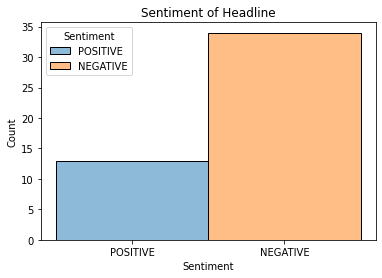

In [12]:
sns.histplot(x = 'Sentiment', data = news_df[news_df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE']).set_title("Sentiment of Headline")

### Sentiment of Content

Text(0.5, 1.0, 'Sentiment of Content')

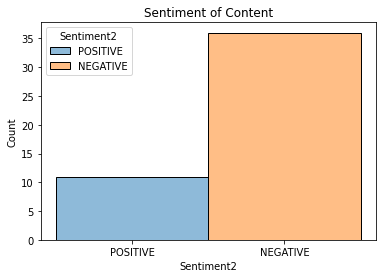

In [13]:
sns.histplot(x = 'Sentiment2', data = news_df[news_df['Score2'] > 0.8], hue = 'Sentiment2', hue_order=['POSITIVE', 'NEGATIVE']).set_title("Sentiment of Content")

In [14]:
import sys
sys.path.insert(1, 'C:/Users/Woon/Desktop/Columbia/Applied Analytics/Term3/Sentiment_SNP')

import helper_functions
from helper_functions import *

In [15]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)


## Each Articles - From Finviz

In [16]:
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import socket
import urllib

In [17]:
url = "https://finviz.com/news.ashx"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    sentence2 = []

    project_href = [i['href'] for i in soup.find_all('a', href=True)]

    for tag in soup.find_all('a', href=True):

        sentence = tag.text.split(".")
        sentence2.append(sentence)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [18]:
df = pd.DataFrame(sentence2)

In [19]:
df['Headline'] = df[0]
df['Sentiment'] = -2
df = pd.DataFrame(list(zip(df['Headline'], df['Sentiment'])), columns=['Headline', 'Sentiment'])
df['Links'] = project_href

In [20]:
df['Links_True'] = list(
    map(lambda x: x.startswith('https'), df['Links']))

df = df[df['Links_True'] == True].reset_index(drop=True)

In [21]:
i = []

for string in df['Headline']:
    i.append(count_words(string))

df['word_count'] = i

In [22]:
sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment'] = sentiment
df['Score'] = sentiment_score

In [23]:
#df = df[df['word_count'] > 10]
df['Headline_Lower'] = df['Headline'].str.lower()

In [24]:
df['article'] = -2 #7
df['summary'] = -2 #8

In [25]:
df.head(2)

,Headline,Sentiment,Links,Links_True,word_count,Score,Headline_Lower,article,summary
0,Former US President Donald Trump sells out NFT trading cards,NEGATIVE,https://www.bbc.co.uk/news/business-63995563?at_medium=RSS&at_campaign=KARANGA,True,10,0.850756,former us president donald trump sells out nft trading cards,-2,-2
1,Goldman Sachs planning to lay off thousands of employees,NEGATIVE,https://foxbusiness.com/economy/goldman-sachs-planning-lay-off-thousands-employees,True,9,0.998038,goldman sachs planning to lay off thousands of employees,-2,-2


In [29]:
headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

article = []

for url in df['Links']:
    req = Request(url, headers=headers)

    try:
        contents = urlopen(req).read() 
        soup = BeautifulSoup(contents, features="html.parser")

        p = soup.find_all('p')
        paragraphs = []
        for x in p:
            paragraphs.append(str(x))

        paragraphs = ''.join(paragraphs)

        article.append(paragraphs) 

    except urllib.error.HTTPError as err:
        print(err.code)

    except socket.timeout as se:
        print("socket timeout")

df['article'] = article


In [31]:
summary_pipeline = pipeline("summarization", model="pszemraj/long-t5-tglobal-base-16384-book-summary")

summary = [None] * len(df)
index = -1
for articles in df['article']:
    index+=1
    result = summary_pipeline(articles[:512])[0]
    summary[index] = result
df.iloc[index][8] = summary

In [ ]:
df